# Setup

## Importing libraries for analysis 

In this example, we'll run through some examples of mining publicly available NF drug screening data for interesting features. First, we'll setup our environment. Then, we'll get the data, and then we'll explore it. 

To explore the data, we will use a dimensionality reduction technique called umap. This is available both as an R and Python package. In this markdown, we'll use the Python implementation `umap`. 


In [1]:
import synapseclient
syn = synapseclient.Synapse()

import os
os.environ['KMP_DUPLICATE_LIB_OK']='TRUE' ##required to keep umap from crashing notebook

import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
pandas2ri.activate()

import numpy as np
import pandas as pd
import seaborn as sns

import umap.umap_ as umap
import matplotlib.pyplot as plt

syn.login()

Welcome, Robert Allaway!



## Prepare the drug-target dataset 

We've already done some of the hard work of mapping NF drug screening IDs together with target data, so we just need to filter down to get a list of targets. We'll assume everything with a pChEMBL >6 is a "real" target. First, we'll get the drug IDs and targets for those drugs:

In [2]:
targetspath = syn.get('syn17091507')
readRDS = robjects.r['readRDS']

targets = readRDS(targetspath.path)

In [3]:
targets_filt = (targets
                .query('mean_pchembl > 6')
                .filter(["internal_id", "hugo_gene", "std_name"])
                .drop_duplicates())
    
pd.DataFrame.head(targets_filt)

,internal_id,hugo_gene,std_name
1,3,HTR7,CHEMBL2413451
2,4,CHRNA4,CHEMBL204871
3,4,CHRNB2,CHEMBL204871
4,5,GSK3A,CHEMBL3582401
5,6,FAAH,CHEMBL2386554


## Prepare the drug screening data 

In these experiments, researchers treat tumors (or cell lines) with drugs or experimental molecules to figure out whether these tumors are sensitive to these drugs. These compounds have molecular _targets_ that the drug binds to and activates or inactivates to affect a biological pathway in the tumors. We'll take a systematic look at all of these to see if a single NF tumor type - plexiform neurofibroma - is sensitive to any particular drug targets. 

This data is standardized across all public NF studies, and a variety of drug metrics were calculated each experiment. These metrics, like IC50, summarize the effect of a drug on a cell line. You can read more about dose-response metrics like IC50s [here](https://www.graphpad.com/support/faq/50-of-what-how-exactly-are-ic50-and-ec50-defined/). 

There are a _lot_ of diverse measurements in this dataset, so we should do a bit to clean up the data and narrow the scope, and eliminate metrics that might not be that accurate. 

Specificially, we will: 

-get the dataset 

-filter for absolute IC50 values only, also known as GI50 (this different than the relative IC50, which is the half-maximal inhibition). While it's not quite as simple as this, you can generally interpret these values as such: the lower this value is, the greater effect the drug has on the cell. 

-filter for NF1 deficient pNF cell lines

-remove outlier cell line 'ipNF95.11b C' (see plot below)

-filter out the combination data (too complicated for a first pass of this method)

-calculate the median IC50 for each drug across all cell lines, when we have an IC50 for at least three cell lines for a given drug. 

-select only the information we need

-`inner_join` on the target dataset to filter out any drugs that we don't have target info for. 

- binarize the target dataset after it has been reduced to only the drugs we can evaluate


In [4]:
drug_data_path = syn.get("syn17462699").path
drug_data = pd.read_csv(drug_data_path, low_memory=False)
                       
pd.DataFrame.head(drug_data)

,model_name,model_type,cellosaurus_id,organism_name,disease_name,disease_efo_id,symptom_name,symptom_efo_id,experiment_synapse_id,study_synapse_id,funder,drug_name,DT_explorer_internal_id,dosage_unit,drug_screen_id,dosage,response_type,response,response_unit
0,ST8814,cell line,CVCL_8916,human,NF1,NaN,MPNST,760.0,syn11958219.1,syn11817821,CTF,(+)-JQ1,103300,uM,1,"[0.00457247370827618,10]",AUC_Simpson,14.146941,NaN
1,ST8814,cell line,CVCL_8916,human,NF1,NaN,MPNST,760.0,syn11958219.1,syn11817821,CTF,BI-847325,136254,uM,10,"[0.00457247370827618,10]",AUC_Simpson,4.021571,NaN
2,ST8814,cell line,CVCL_8916,human,NF1,NaN,MPNST,760.0,syn11958219.1,syn11817821,CTF,Rapamycin (Sirolimus),179479,uM,100,"[0.00457247370827618,10]",AUC_Simpson,20.871279,NaN
3,HCT116 p53-,cell line,CVCL_HD97,human,cancer,311.0,colorectal carcinoma,1001951.0,syn11958252.1,syn11817821,CTF,OSU-03012 (AR-12),258505,uM,1000,"[0.00457247370827618,10]",AUC_Simpson,35.699172,NaN
4,ipNF05.5,cell line,NaN,human,NF1,NaN,pNF,658.0,syn5522645.1,syn4939906,NTAP,NCGC00347953-01,313286,uM,10000,"[0.000780415,46.08295]",AUC_Simpson,50.102748,NaN


[Text(0, 0, 'ipNF05.5'),
 Text(0, 0, 'ipNF06.2A'),
 Text(0, 0, 'ipNF95.11b C/T'),
 Text(0, 0, 'ipnNF95.11C'),
 Text(0, 0, 'ipNF95.6'),
 Text(0, 0, 'ipNF05.5 (mixed clone)'),
 Text(0, 0, 'ipNF95.11b C')]

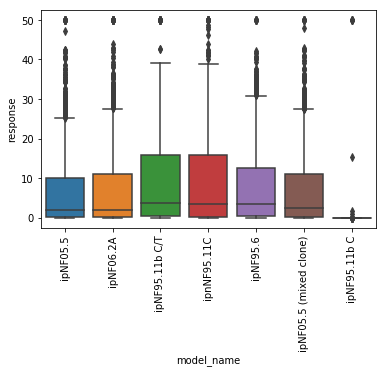

In [5]:
pnf = ["ipNF05.5", "ipNF06.2A", "ipNF95.11b C/T", "ipnNF95.11C", "ipNF95.6", "ipNF05.5 (mixed clone)", "ipNF95.11b C"]

drug_data_pnf = (drug_data
      .query('response_type == "IC50_rel"')
      .query('model_name == @pnf')
      .groupby('drug_screen_id').filter(lambda x: len(x)==1)
      .assign(response = lambda x: [50 if a >= 50 else a for a in x['response']]))
 
pd.DataFrame.head(drug_data_pnf)

ax = sns.boxplot(x = "model_name", y = "response", data = drug_data_pnf)
ax = ax.set_xticklabels(ax.get_xticklabels(),rotation=90)

ax

In [6]:
drug_data_filt = (drug_data_pnf
                  .query('model_name != "ipNF95.11b C"')
                  .groupby('DT_explorer_internal_id').filter(lambda x: len(x)>3)
                  .filter(['DT_explorer_internal_id', 'response','model_name'])
                  .groupby(['DT_explorer_internal_id','model_name'],as_index = False).median())

target_data_filt = (drug_data_pnf
                    .merge(targets, 
                             left_on = "DT_explorer_internal_id",
                             right_on = "internal_id",
                             how = "inner")
                    .filter(["DT_explorer_internal_id", "hugo_gene"])
                   .assign(foo = 1)
                   .pivot_table(values = 'foo', index = 'DT_explorer_internal_id', columns = "hugo_gene", fill_value = 0))
                 

In [7]:
pd.DataFrame.head(target_data_filt)
pd.DataFrame.head(drug_data_filt)

,DT_explorer_internal_id,model_name,response
0,458,ipNF05.5,0.001354
1,458,ipNF05.5 (mixed clone),0.006432
2,458,ipNF06.2A,0.003290
3,458,ipNF95.11b C/T,0.002239
4,458,ipNF95.6,0.140535


# Dose-response visualization

To get a sense of what this data usually looks like, we can take a look at some specific drugs. mTOR inhibitors are a class of drugs known to inhibit plexiform neurofibromas. KIF11 inhibitors are not associated with this (as far as we know).

Let's plot a heatmap of the IC50s of all of the MTOR and KIF11 inhibitors in our dataset:


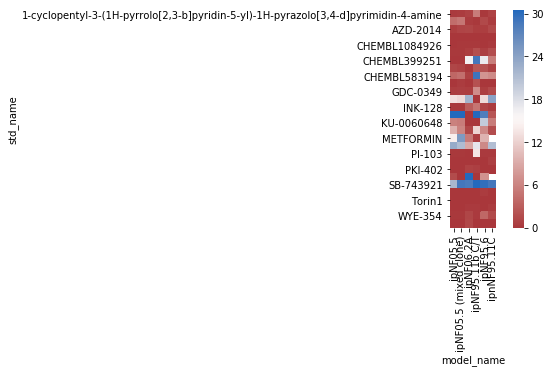

In [8]:
mtor = (targets
       .query('hugo_gene == "MTOR"')
       .filter(["internal_id", "std_name"])
       .drop_duplicates()
       .assign(target = "mTOR"))

kif11 = (targets
       .query('hugo_gene == "KIF11"')
       .filter(["internal_id", "std_name"])
       .drop_duplicates()
       .assign(target = "KIF11"))

mtor_kif11 = (pd.concat([mtor, kif11]))
mtor_kif11 = mtor_kif11[mtor_kif11['internal_id'].isin(drug_data_filt['DT_explorer_internal_id'])]

drug_data_filt_heatmap = drug_data_filt[drug_data_filt['DT_explorer_internal_id'].isin(mtor_kif11['internal_id'])]
 
drug_data_filt_heatmap = (drug_data_filt_heatmap 
                          .filter(['model_name', 'response', 'DT_explorer_internal_id'])
                          .join(mtor_kif11.set_index('internal_id'), on='DT_explorer_internal_id')
                          .drop(['DT_explorer_internal_id'], axis = 1)
                          .query('std_name != "TACROLIMUS"')
                          .pivot_table(values = 'response', index = 'std_name', columns = "model_name", fill_value = np.nan))

sns.heatmap(drug_data_filt_heatmap, square = True, robust = True, cmap = sns.cm.vlag_r)

It looks like KIF11 targeting drugs (gossypol, ispinesib, sb-743921 and CHEMBL399251) are generally not effective (high IC50) while mTOR inhibitors are quite potent (IC50 < 5 nM). However, this is an oversimplification. Most of these molecules have many targets, not just one, and there's lots of overlap between molecules. It might be better to map the space of all targets of a drug rather than just look at one at a time. One approach to doing this is to use a dimensionality reduction technique. 

## Dimensionality Reduction

To do this, we can take the binarized target matrix (`target_data_filt`) and use UMAP (`umap`) to reduce the dimensionality of the matrix. This allows us to visualize the grouping. You can learn more about how umap works in the [umap-learn documentation](https://umap-learn.readthedocs.io/en/latest/how_umap_works.html), but it's sufficient for this markdown to simply understand that we are taking a high-dimension space (drugs with many possible targets) and representing this in two dimensions, similarly to principal components analysis (PCA) or t-stochastic neighbor embedding (t-SNE). 


In [9]:
fit = umap.UMAP(
        n_neighbors=3,
        n_components=2,
        metric='euclidean'
    )

u = fit.fit_transform(target_data_filt)


[WARNING] /anaconda3/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 22 separate connected components using meta-embedding (experimental)
  n_components



Here's a quick plot of the results: 

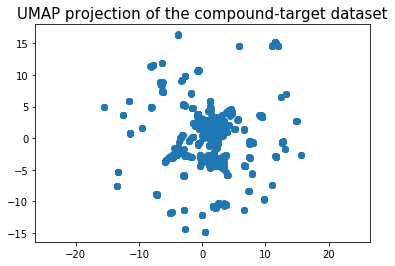

In [10]:
plt.scatter(u[:, 0], u[:, 1])
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the compound-target dataset', fontsize=15);

## Plot results

That plot is helpful, but let's layer some more information in to make it more informative.

First, prep and map together data so we have median IC50 and standard names available to plot:

In [11]:
df = pd.DataFrame(u)
drugs = target_data_filt.index

df.columns = ['x', 'y']

df['internal_id'] = drugs

std_names = (targets
             .filter(['internal_id', 'std_name'])
             .drop_duplicates())
             
drug_data_pnf_median = (drug_data_pnf
                  .query('model_name != "ipNF95.11b C"')
                  .groupby('DT_explorer_internal_id').filter(lambda x: len(x)>3)
                  .filter(['DT_explorer_internal_id', 'response'])
                  .groupby(['DT_explorer_internal_id'],as_index = False).median())


df = (df
      .merge(std_names, how = 'left')
      .merge(drug_data_pnf_median, left_on = 'internal_id', right_on = "DT_explorer_internal_id", how = "left")
     .sort_values(['response'], ascending = True))


Then, plot using `matplotlib`. Here, we're looking at the 2 dimensions generated by UMAP. Each point is a drug, it's position is determined by it's target profile, and we've colored each by the pIC50 (log(IC50, median across all pNF cell lines)). Also, let's label the drug names where the IC50 is 50nM or less, which is a pretty potent response in cell lines.

233

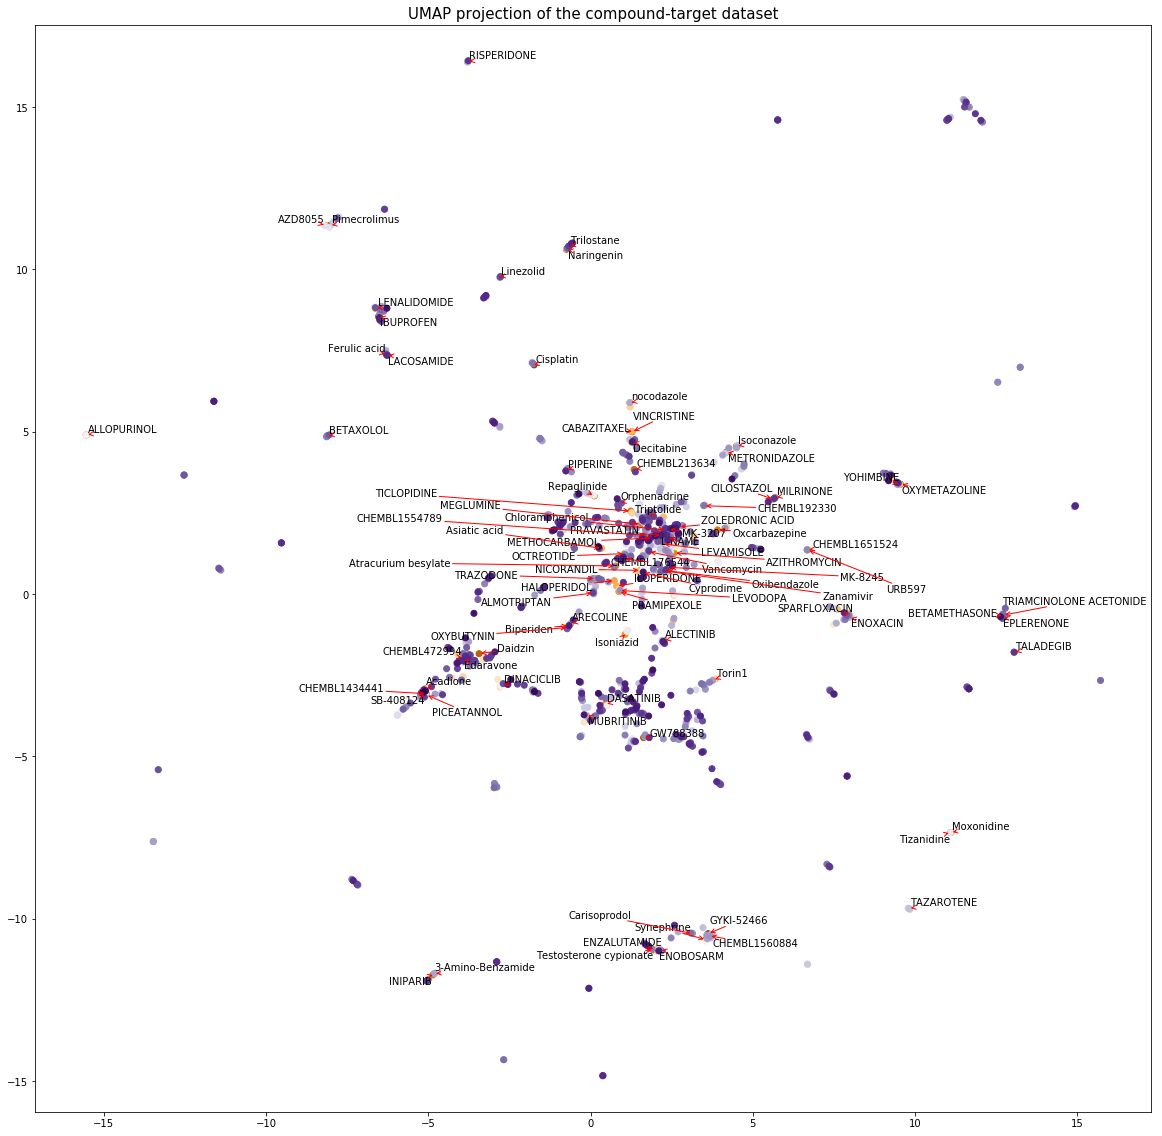

In [12]:

from adjustText import adjust_text

plt.figure(figsize=(20,20))
plt.scatter(df.x, df.y, c = np.log(df.response), cmap = 'PuOr')
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the compound-target dataset', fontsize=15);

df_short = (df
     .query('response < 0.05')
     .reset_index(drop = True))

texts = [plt.text(df_short.x[i], df_short.y[i], df_short.std_name[i], ha='center', va='center') for i in range(len(df_short.x))]
adjust_text(texts, arrowprops=dict(arrowstyle='->', color='red'))

## Clustering

What if instead of single drugs, we want to identify groups of drugs with a low median IC50? 

Well, we can use `umap` to reduce the dimensionality of the drug-target data, and then cluster these reduced dimensions using a method like HDBSCAN. So let's do that. I've taken the suggestion of the umap-learn documentation and doubled the number of nearest neighbors from before, (3 to 6). I've also moved from 2 components for nicer visualization, to 3 for some more separation. I tried several numbers of components between 3 and 50, and found that anything above three resulted in too many small clusters to be useful.

Then, simply cluster the x/y data with `hdbscan`. 

In [13]:
fit = umap.UMAP(
        n_neighbors=6,
        n_components=3,
        metric='euclidean'
    )

u = fit.fit_transform(target_data_filt)

import hdbscan
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

df = pd.DataFrame(u)
df.columns = ['x', 'y', 'z']

labels = hdbscan.HDBSCAN(
    min_cluster_size=3
).fit(df)

Here's a dendrogram showing the breakdown of the various clusters identified:

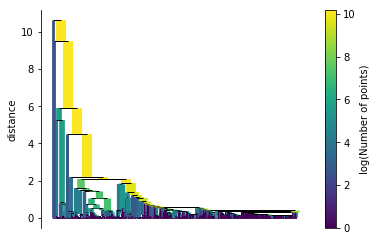

In [14]:
labels.single_linkage_tree_.plot()

We can also color the individual clusters as defined by HDBSCAN. There are lots of very close clusters, so this isn't the most straightforward visualization, but you can get a general sense that the color of the cluster maps closely to the magnitude of the components for each point - i.e. clusters are spatially visible. 

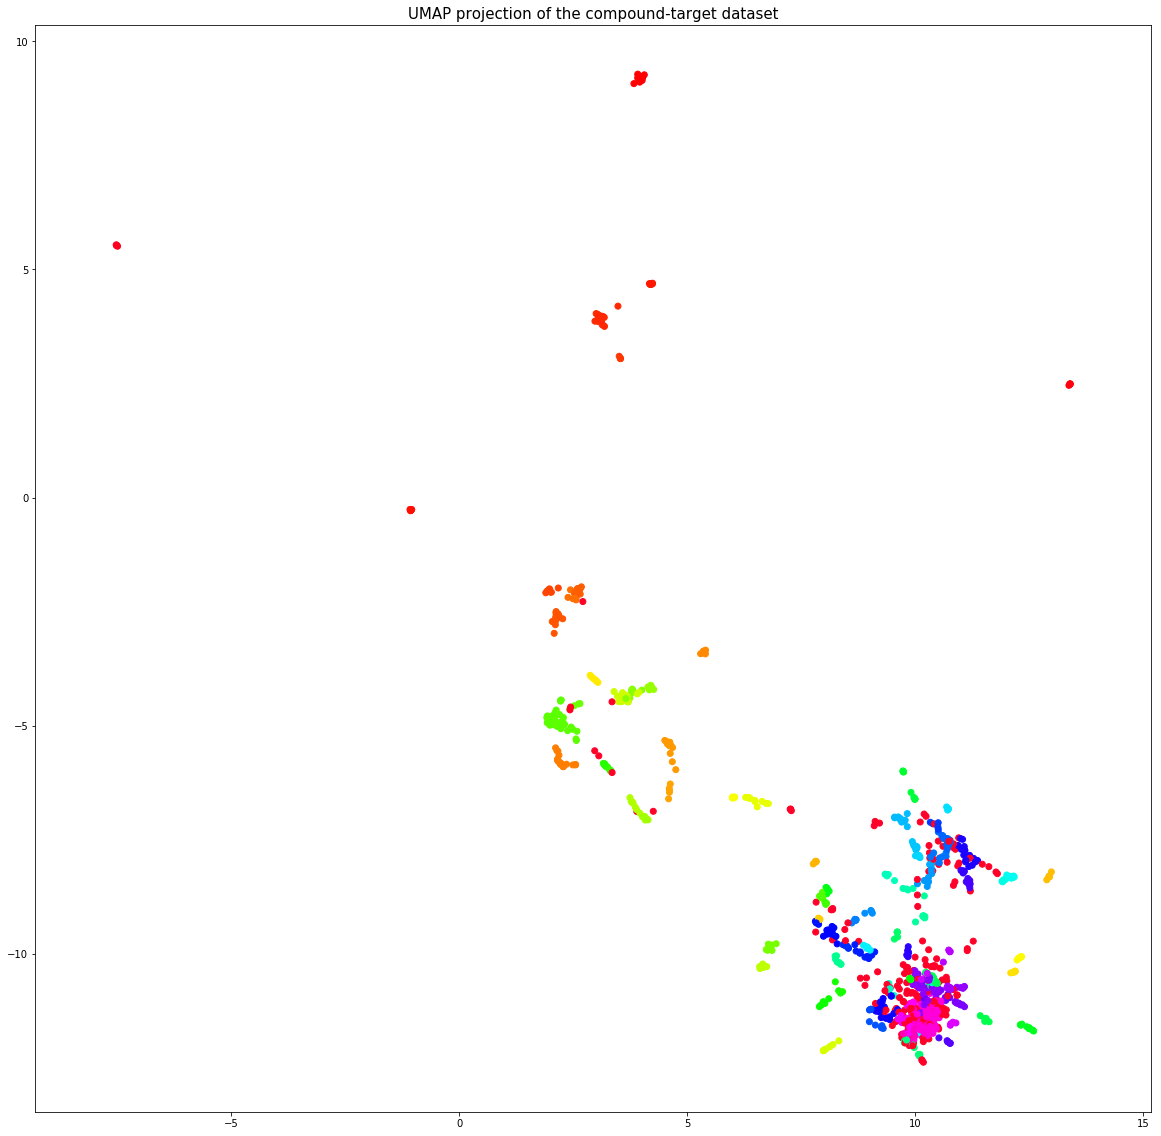

In [15]:
df['labels'] = labels.labels_

plt.figure(figsize=(20,20))
plt.scatter(df.x, df.y, c = df.labels, cmap = 'gist_rainbow')
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the compound-target dataset', fontsize=15);


Finally, we can select for only the best clusters and plot some labels see what drugs are in them Here, I'm filtering only for clusters that have a median IC50 < 250 nM across all cell lines and drugs for that cluster. An important note - this is the _median IC50_ for each cluster, so some of these drugs may have had no effect, and that could be masked by the overall cluster average. 

247

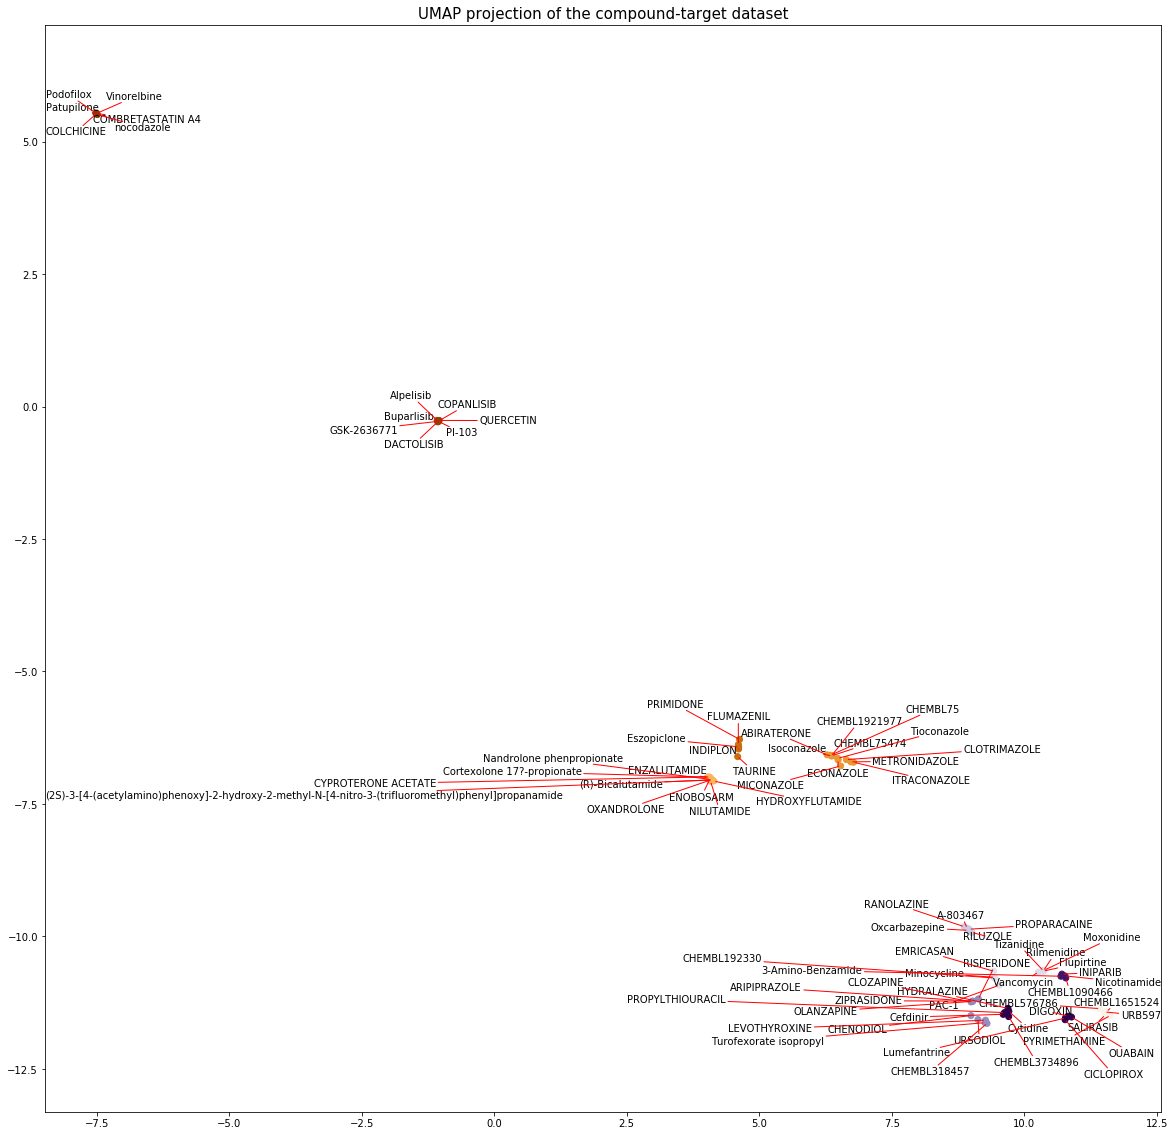

In [16]:
df['internal_id'] = drugs

drug_data_pnf_clustered = (drug_data_pnf
                           .merge(df, right_on = 'internal_id', left_on = "DT_explorer_internal_id", how = "right")
                           .filter(['labels','response'])
                           .groupby(['labels'],as_index = False).median())


df_short = (df
      .merge(drug_data_pnf_clustered, how = "left")
      .sort_values(['response'], ascending = True)
      .query('response < 0.25') 
      .merge(std_names, how = 'left')
      .reset_index(drop = True))

plt.figure(figsize=(20,20))
plt.scatter(df_short.x, df_short.y, c = df_short.labels, cmap = 'PuOr')
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the compound-target dataset', fontsize=15);

texts = [plt.text(df_short.x[i], df_short.y[i], df_short.std_name[i], ha='center', va='center') for i in range(len(df_short.x))]
adjust_text(texts, arrowprops=dict(arrowstyle='-', color='red'))